In [1]:
import os
import json
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from recsys.models import NeuMF
from recsys.data.movielens import MovielensDataset
from recsys.utils.metrics import evaluate
from recsys.utils import recommender, visualizer

In [2]:
with open("../configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)

with open(config["data"]["experiment_group"], "r") as f:
    experiment_group = json.load(f)
experiment_group[NeuMF.model_name] = []
    
with open(config["data"]["num_sparse_features"], "r") as f:
    num_sparse_features = json.load(f)
    
with open(config["data"]["dense_features"], "r") as f:
    dense_features = json.load(f)

train = pd.read_parquet(config["data"]["train"])
test = pd.read_parquet(config["data"]["test"])
num_sparse_features = {k:v for k,v in num_sparse_features.items() if k in ["user_id", "item_id"]}

In [3]:
# Define Dataset
train_ds = MovielensDataset(train, list(num_sparse_features.keys()), dense_features)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config["training"]["batch_size"], shuffle=True)

test_ds = MovielensDataset(test, list(num_sparse_features.keys()), dense_features)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=test["item_id"].nunique(), shuffle=False)

device = torch.device(config["training"]["device"])
model = NeuMF(num_sparse_features=num_sparse_features, **config["models"][NeuMF.model_name])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
print(model)

NeuMF(
  (gmf): GeneralizedMatrixFactorization(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
    )
  )
  (ncf): NeuralCollaborativeFiltering(
    (sparse_arch): ModuleDict(
      (user_id): Embedding(943, 16)
      (item_id): Embedding(1682, 16)
    )
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
    )
  )
  (classifier): Linear(in_features=48, out_features=1, bias=True)
)


Epoch 1/10: 100%|█| 5747/5747 [00:39<00:00, 146.01it/s, auc=0.0000, logloss=0.23
Epoch 2/10: 100%|█| 5747/5747 [00:41<00:00, 137.54it/s, auc=0.7542, logloss=0.33
Epoch 3/10: 100%|█| 5747/5747 [00:39<00:00, 147.28it/s, auc=0.8228, logloss=0.28
Epoch 4/10: 100%|█| 5747/5747 [00:38<00:00, 149.20it/s, auc=0.8311, logloss=0.27
Epoch 5/10: 100%|█| 5747/5747 [00:38<00:00, 148.27it/s, auc=0.8390, logloss=0.41
Epoch 6/10: 100%|█| 5747/5747 [00:38<00:00, 148.28it/s, auc=0.8482, logloss=0.41
Epoch 7/10: 100%|█| 5747/5747 [00:36<00:00, 155.67it/s, auc=0.8605, logloss=0.21
Epoch 8/10: 100%|█| 5747/5747 [00:37<00:00, 154.81it/s, auc=0.8743, logloss=0.36
Epoch 9/10: 100%|█| 5747/5747 [00:37<00:00, 153.74it/s, auc=0.8866, logloss=0.23
Epoch 10/10: 100%|█| 5747/5747 [00:37<00:00, 153.96it/s, auc=0.8975, logloss=0.1


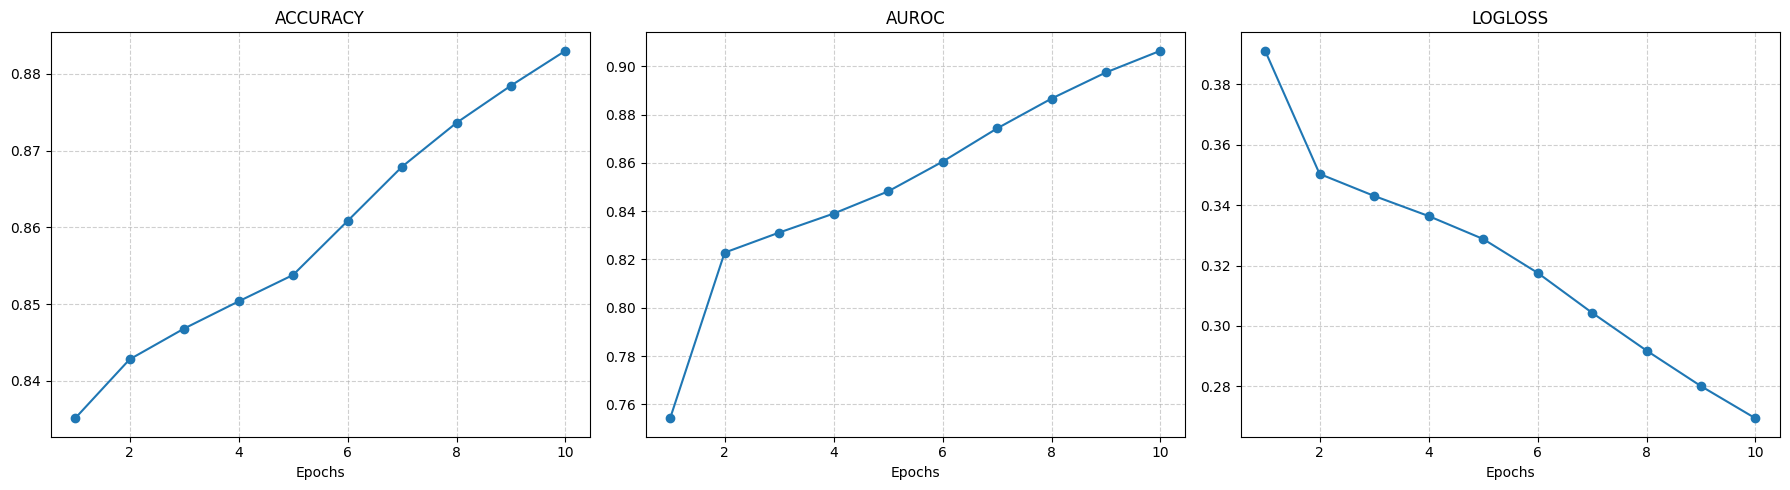

In [4]:
history = recommender.train(model, train_loader, optimizer, device, config["training"]["epochs"])
visualizer.plot_history(history)

Recommend (neumf): 100%|█████████| 943/943 [00:11<00:00, 80.17it/s, user_id=942]


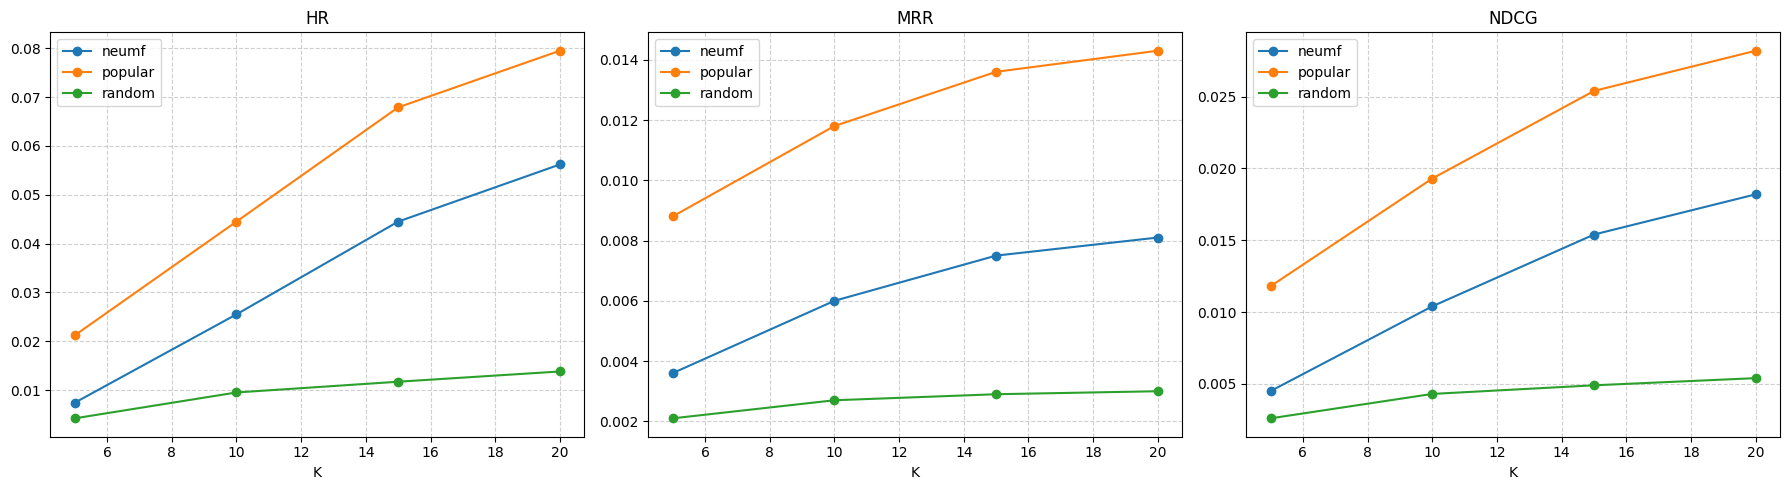

In [5]:
os.makedirs("results", exist_ok=True)
user_recommendations = recommender.inference(model, device, test_loader)
with open(f"results/{model.model_name}.json", "w") as f:
    json.dump({
        k: v.tolist() for k, v in user_recommendations.items()
    }, f)

ks = [5, 10, 15, 20]
_test = test[test["rating"]==1]
recommendations = {
    "popular": np.array(experiment_group["popular"]),
    "random": np.array(experiment_group["random"]),
    model.model_name: user_recommendations
}
results = evaluate(_test, recommendations, ks)
visualizer.plot_metrics(results)